# Endothelium trajectory

In [2]:
import sys
import subprocess

%matplotlib inline
import re
import glob
import os
import sys

import scanpy as sc
import scvelo as scv
import cellrank as cr
import scvi
import numpy as np
import pandas as pd
import pickle as pkl#
import scipy
import sklearn #

import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)

from numpy import cov
from collections import Counter
from collections import defaultdict
from collections.abc import Iterable
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from matplotlib import rcParams

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

rcParams['figure.figsize'] = 20,20

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

import torch
print('cuda availability : {}'.format(torch.cuda.is_available()))
print('cuda count : {}'.format(torch.cuda.device_count()))
print(torch.version.cuda)

Global seed set to 0


cuda availability : False
cuda count : 0
11.7


# Prepare data

In [2]:
# obj paths for spliced unspliced information
 
data = {
# 'fski_raw':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/FS_new_Gene_raw_sliced_raw.h5ad', # Object containing raw counts pre-QC slicing
# 'fski_qc_raw':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/FS_new_Gene_raw_sliced_processed.h5ad', # Object containing raw counts post-QC slicing
# 'fskin_NI_raw':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/fetal_skin_raw.h5ad',
# 'fskin_NI_QC_maternal_removed':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/fetal_skin.norm.maternal_removed.20220202.h5ad', # previous Ni's filtered ver of the obj with QC removed
# 'fski_qc_norm':'/nfs/team205/ig7/projects/fetal_skin/data/A1_V1_FS_new_Gene_norm_qc_sliced.h5ad',
    
'fski_qc_norm_scvi':'/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/A1_V1_FS_new_Gene_norm_qc_sliced_scvi.h5ad',
'fski_velocyto':'/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/FS_new_Velocyto_raw_combined_processedsize.h5ad',
#'fski_qc_norm_ldvae':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/A1_V1_FS_new_Gene_norm_qc_ldvae.h5ad',
}

In [3]:
# Dinithis Palantir object
adata = sc.read('/nfs/team298/ew17/fetal_skin/Endo_dpt_palantir_pseudotme_estimated.h5ad')

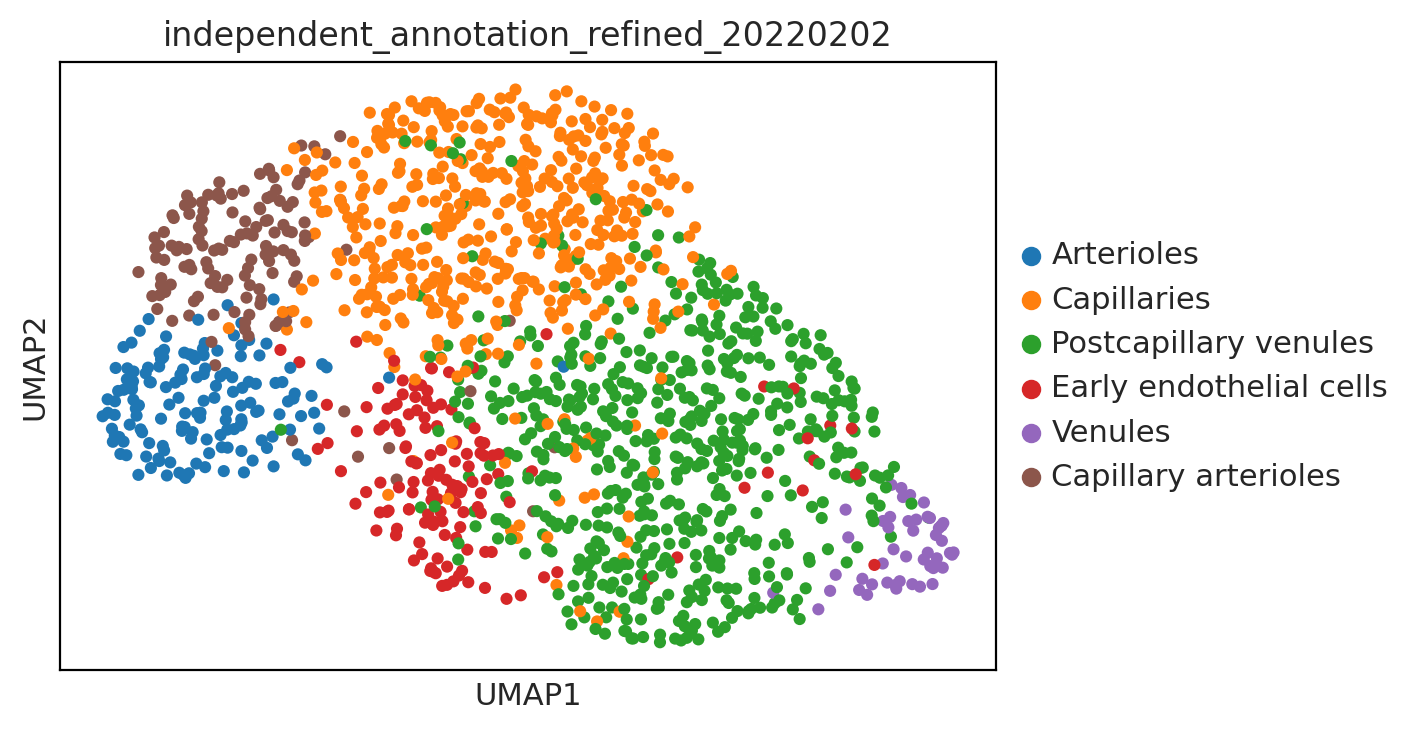

index
CTACATTCAGGTCGTC-1-4834STDY7002879              Capillaries
GCATACAGTAGCTCCG-1-4834STDY7002879              Capillaries
GCGCGATGTATAGGGC-1-4834STDY7002879     Capillary arterioles
AATCCAGTCGGTTCGG-1-FCAImmP7241241     Postcapillary venules
ACGAGCCTCGGACAAG-1-FCAImmP7241241               Capillaries
                                              ...          
TGATTTCAGCTTATCG-1-FCAImmP7964510                Arterioles
TGATTTCGTCTCTTTA-1-FCAImmP7964510                Arterioles
TTGGAACTCTATCGCC-1-FCAImmP7964510     Postcapillary venules
TTTATGCAGGCTACGA-1-FCAImmP7964510     Postcapillary venules
TTTGGTTAGCCACTAT-1-FCAImmP7964510                Arterioles
Name: independent_annotation_refined_20220202, Length: 1567, dtype: category
Categories (6, object): ['Arterioles', 'Capillaries', 'Postcapillary venules', 'Early endothelial cells', 'Venules', 'Capillary arterioles']

In [6]:
# Have a look at  object
sc.pl.umap(adata, color='independent_annotation_refined_20220202')

# How are the populations called in this object?
adata.obs['independent_annotation_refined_20220202']

In [7]:
# Isaacs script to load the data in
def load_adatas(adatas_dict,data_merge, data_key_use,QC_normalise,backed=None):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
            adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            print('Loading anndata {} from local source'.format(dataset))
            if backed == 'r':
                print('Loading data in backed mode! To move into memory run .to_memory()')
            adatas[dataset] = sc.read(adatas_dict[dataset],backed)
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
#             adatas[dataset].obs.index = adatas[dataset].obs.index + dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
            print('All datasets successfully read into a dictionary')
        print('Attempting to collapse dictionary into single joint concatenation')
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner',index_unique=None) # consider only genes that are intersecting
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            print('Loading anndata {} from local source'.format(data_key_use))
            if backed == 'r':
                print('Loading data in backed mode! To move into memory run .to_memory()')
            adata = sc.read(adatas_dict[data_key_use],backed)
    if QC_normalise == True:
        print('option to apply standardisation to data detected, performing basic QC filtering')
        print('Warning we have not implemented a norm check here, so we assume your inut here is raw!')
        adata.raw = adata[:]
        print('Anndata shape is {}'.format(adata.shape))
        #sc.pp.filter_cells(adata, min_genes=200) # No cell filters heren as we want the same [0] dimension as previous analyses
        #sc.pp.filter_genes(adata, min_cells=10) # 
        print('QC filtered Anndata shape is {}'.format(adata.shape))
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
    return adata


Loading anndata fski_qc_norm_scvi from local source
Loading data in backed mode! To move into memory run .to_memory()
Loading anndata fski_velocyto from local source
Loading data in backed mode! To move into memory run .to_memory()


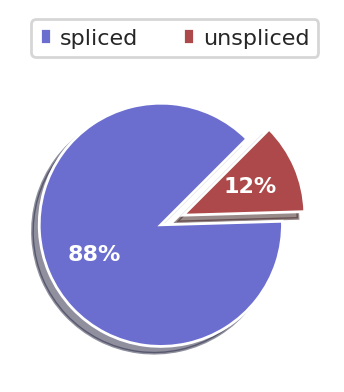

In [8]:
# Addition of data keys and exclusion of all populations that are not interesting here
data_key_use = 'fski_qc_norm_scvi'
velo_data = 'fski_velocyto'
var_key = 'independent_annotation_refined_20220202'
subset_keys = [
    
 'Capillaries',
 'Capillary arterioles',
 'Postcapillary venules',
 'Early endothelial cells',
 'Arterioles',
 'Venules'] #'vascular endothelium'
adata_r = load_adatas(data,data_merge = False, data_key_use = data_key_use, QC_normalise = False,backed='r')
adata = adata
adata_vr = load_adatas(data,data_merge = False, data_key_use = velo_data, QC_normalise = False,backed='r')
adata_v = adata_vr[adata_vr.obs.index.isin(adata.obs.index)].to_memory()
scv.pl.proportions(adata_v)
adata_v
var_name = var_key


In [8]:
var_key = 'independent_annotation_refined_20220202'
integrate = False
lin_vae = False
batches = ['chemistry_sorting','donor', 'gender', 'cell_caller']
labels_key = var_key
var_name =var_key
lin_vae=False

In [10]:
# Look at cell number to see how long it will take
adata_v

AnnData object with n_obs × n_vars = 1567 × 36601
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'age'
    var: 'gene_ids', 'feature_types'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [11]:
# Integrate  object with splicing information
def scvi_integrate_time(adata,lin_vae,batches,labels_key ):
    if lin_vae == True:
        arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        n_hidden=128)

        scvi.model.LinearSCVI.setup_anndata(
        adata,
        labels_key = 'annot',
        layer=None,
        batch_key='lr_batch')

        vae = scvi.model.LinearSCVI(adata, n_latent=20, **arches_params)
        #vae = scvi.model.SCVI(adata, n_latent=30,n_hidden=256, **arches_params)
        vae.train(early_stopping=True,
            train_size=0.2,
            early_stopping_patience=45,
            max_epochs=250, 
            batch_size=1024, 
            limit_train_batches=10#,use_gpu=True
           )
        X_scvi = vae.get_latent_representation()
        X_loading = vae.get_loadings()
        adata.obsm['X_scvi'] = X_scvi
        adata.varm['X_scvi'] = X_loading
    else:
        scvi.model.SCVI.setup_anndata(
        adata,
        layer=None,
        categorical_covariate_keys = batches,
        )
        arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        n_hidden=256
        )
        vae = scvi.model.SCVI(adata, n_latent=20,**arches_params)
        vae.train(early_stopping=True,
                train_size=0.5,
                early_stopping_patience=45,
                max_epochs=250, 
                batch_size=1024, 
                limit_train_batches=10#,use_gpu=True
               )
        X_scvi = vae.get_latent_representation()
        adata.obsm['X_scvi'] = X_scvi
        return adata


In [12]:
adata_v = scvi_integrate_time(adata_v,lin_vae,batches,labels_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 250/250: 100%|██████████| 250/250 [20:20<00:00,  4.90s/it, loss=7.84e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [20:20<00:00,  4.88s/it, loss=7.84e+03, v_num=1]


In [13]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/Dinithi_scvelo_endo_a1.h5ad"
adata_v.write(filename, compression="lzf")

# Start with velocity analysis

In [14]:
# adata_v = adata_v[:,adata.var.index]
scv.pp.filter_genes(adata_v, min_shared_counts=20)
scv.pp.normalize_per_cell(adata_v)
scv.pp.filter_genes_dispersion(adata_v, n_top_genes=10000)
scv.pp.log1p(adata_v)

Filtered out 31016 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


/tmp/ipykernel_29692/3258196454.py:5: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_v)


In [15]:
# Copy Dinithi object and scvi object together
# move graph
partitions = {
'obsm': adata.obsm,
'obs':adata.obs,
'obsp':adata.obsp,
'uns':adata.uns,
}
for partition_key in partitions:
    # this automtically loads the slice into memory, else use the .to_memory() function
    setattr(adata_v,partition_key,partitions[partition_key]) 
adata = adata_v.copy()

In [5]:
#adata = sc.read('/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/Dinithi_scvelo_endo_final.h5ad')

In [6]:
kernel = 'scv'#CTK #None defaults to just scVELO
outlier_lambda = -1 # (-) negative values lower the threshold by x*std around the mean of the cluster centeroid
outlier_embedding = 'scvi'
use_smoothing_kernel = True
smoothing_kernel = 'CTK' #or connectivity
basis = 'umap'
ck_weight = 0.3
i_ck_weight = 0.7

In [7]:
print('Computing First and second order splicing dynamics')
scv.pp.moments(adata, use_rep = 'X_scVI', n_pcs=10, n_neighbors=30)# Compute first and second order moments for each cell using the SCVI neighbor graph


Computing First and second order splicing dynamics
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/60 cores)


  0%|          | 0/1567 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


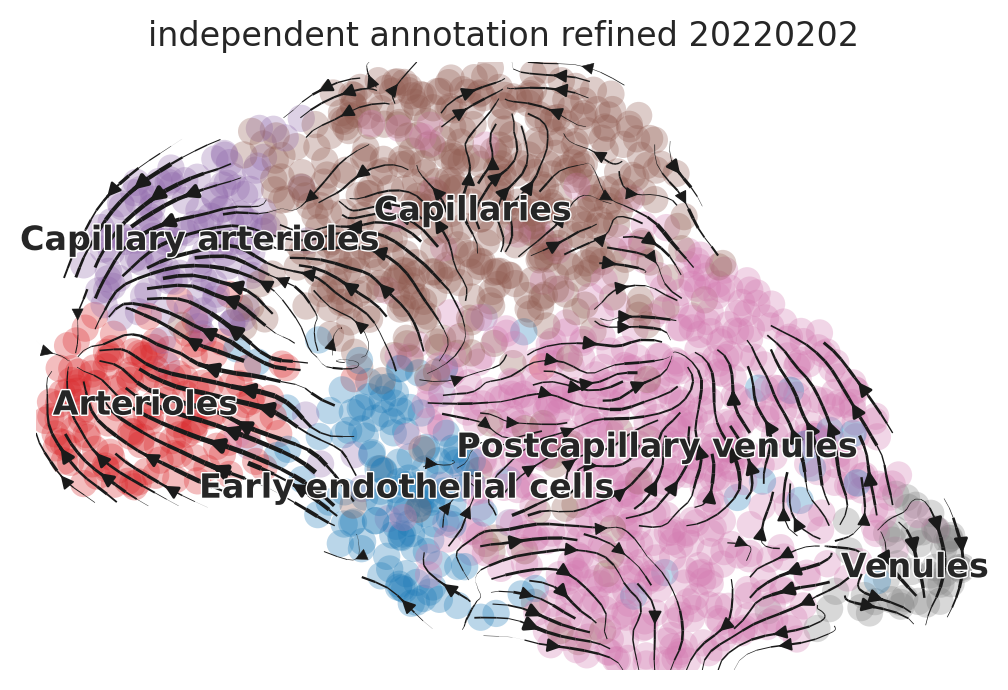

In [9]:
scv.tl.velocity(adata)

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=var_name)

In [10]:
print('Computing scv transition matrix representation and embeddings')
from cellrank.kernels import VelocityKernel
scv.tl.recover_dynamics(adata, n_jobs=1) #, n_jobs=-1
scv.tl.velocity(adata)


Computing scv transition matrix representation and embeddings
recovering dynamics (using 1/60 cores)


  0%|          | 0/578 [00:00<?, ?gene/s]

    finished (0:02:53) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [20]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/Dinithi_scvelo_endo_organoid_b1.h5ad"
adata.write(filename, compression="lzf")

In [12]:
from cellrank.kernels import PseudotimeKernel
pk = PseudotimeKernel(adata, time_key='palantir_pseudotime')
pk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)


from cellrank.kernels import VelocityKernel
vk = VelocityKernel(adata)
vk.compute_transition_matrix()


Computing transition matrix based on pseudotime


  0%|          | 0/1567 [00:00<?, ?cell/s]

    Finish (0:00:00)
Computing transition matrix using `'deterministic'` model


  0%|          | 0/1567 [00:00<?, ?cell/s]

Using `softmax_scale=15.5809`


  0%|          | 0/1567 [00:00<?, ?cell/s]

    Finish (0:00:04)


VelocityKernel[n=1567, model='deterministic', similarity='correlation', softmax_scale=15.581]

In [22]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/Dinithi_scvelo_endo_organoid_b1.h5ad"
adata.write(filename, compression="lzf")

Using precomputed projection `adata.obsm['T_fwd_umap']`


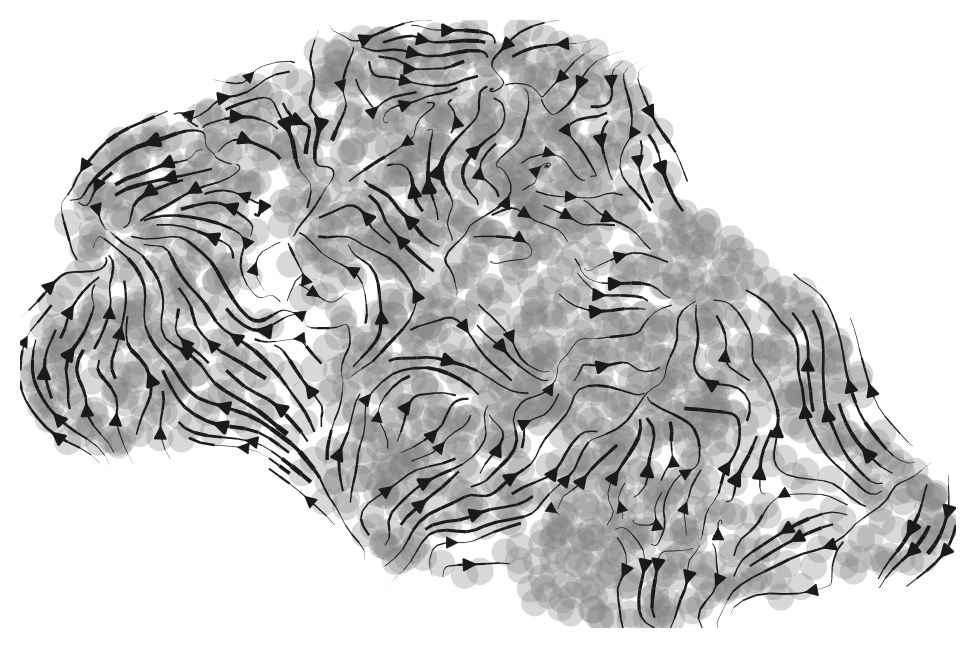

In [13]:
vk.plot_projection(basis="umap", key_added='T_fwd')


Using precomputed projection `adata.obsm['T_fwd_4_umap']`


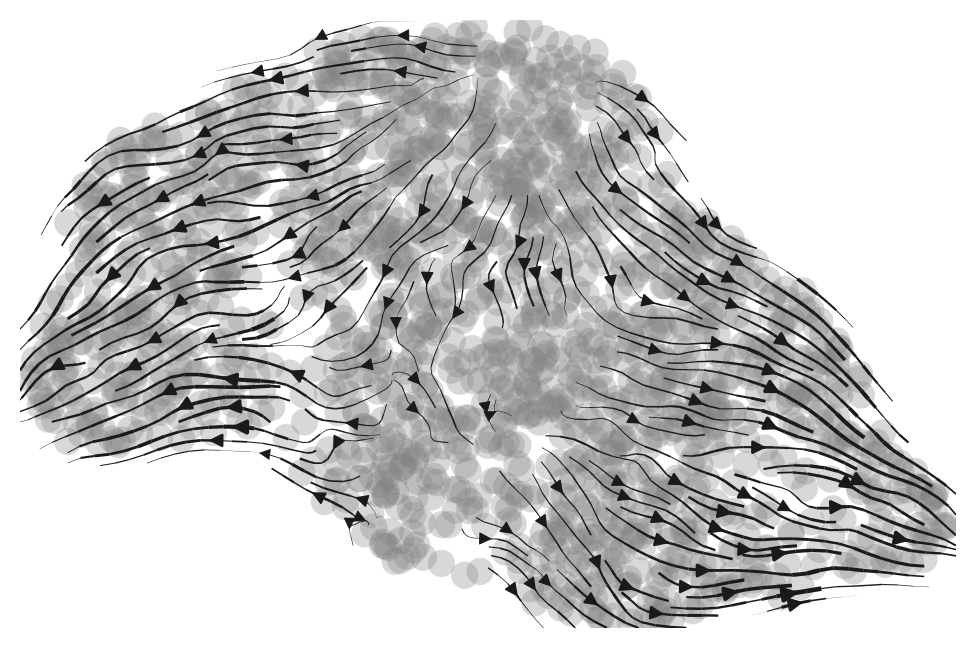

In [14]:
pk.plot_projection(basis="umap", key_added='T_fwd_4')


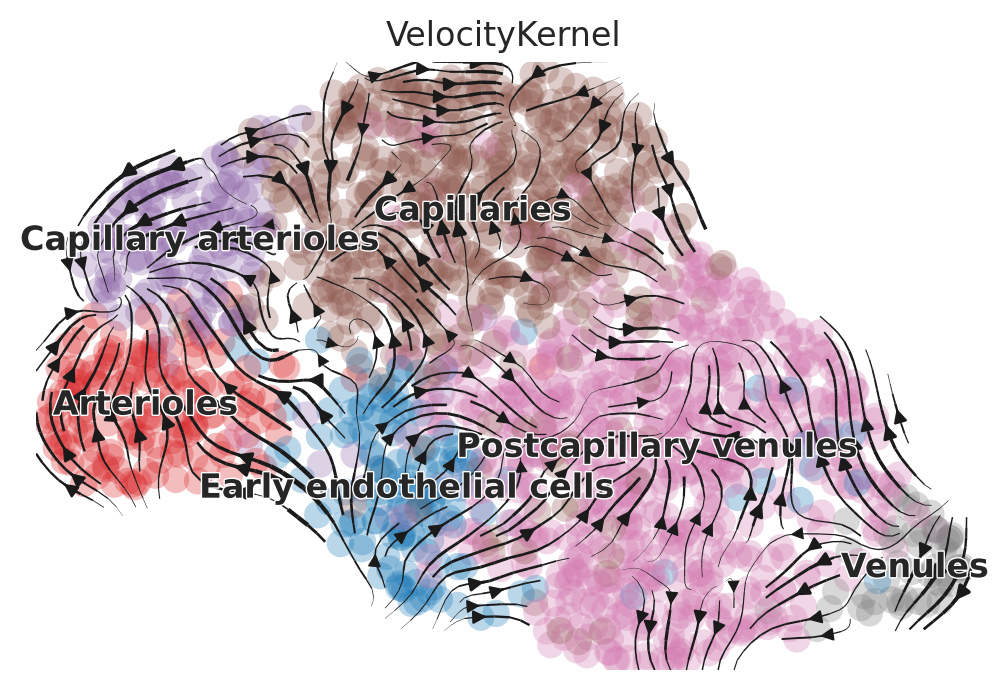

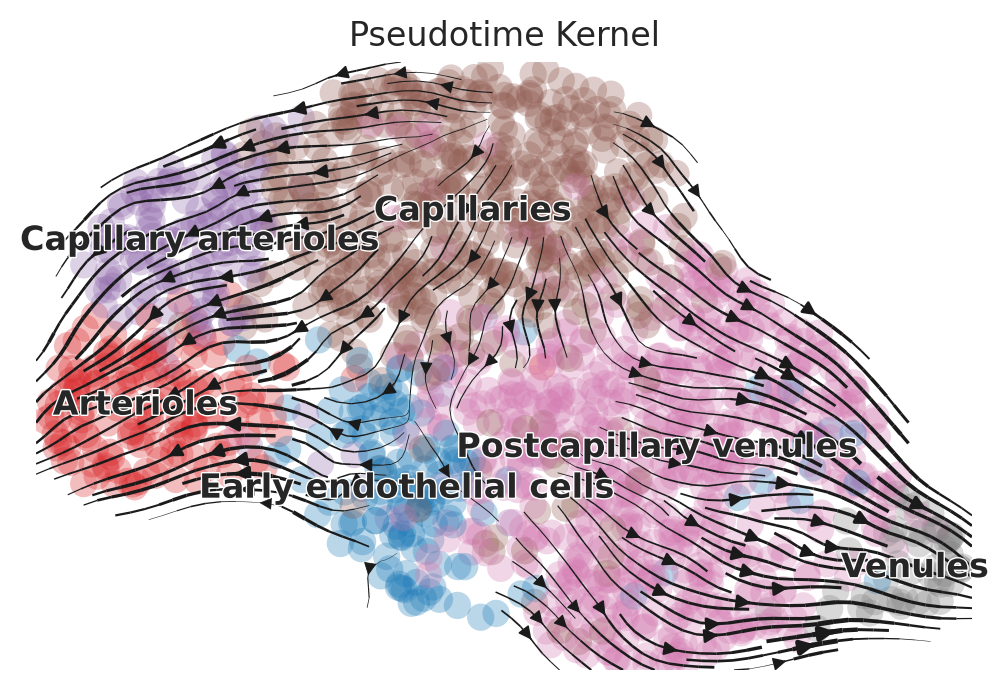

In [15]:
#Plot umaps
scv.pl.velocity_embedding_stream(adata, color=var_name,basis="umap",vkey="T_fwd", legend_fontsize=12, title="VelocityKernel", smooth=0.8, min_mass=3)
scv.pl.velocity_embedding_stream(adata, color=var_name,basis="umap",vkey="T_fwd_4", legend_fontsize=12, title="Pseudotime Kernel", smooth=0.8, min_mass=3)

In [16]:
kernel = 'scv'#CTK #None defaults to just scVELO
outlier_lambda = -1 # (-) negative values lower the threshold by x*std around the mean of the cluster centeroid
outlier_embedding = 'scvi'
use_smoothing_kernel = True
smoothing_kernel = 'CTK' #or connectivity
basis = 'umap'
first_weight = 0.3
second_weight = 0.7
third_weight = 0.5

In [18]:
combined_kernel5 = third_weight * vk + third_weight * pk


Using precomputed projection `adata.obsm['T_fwd_wck5_umap']`


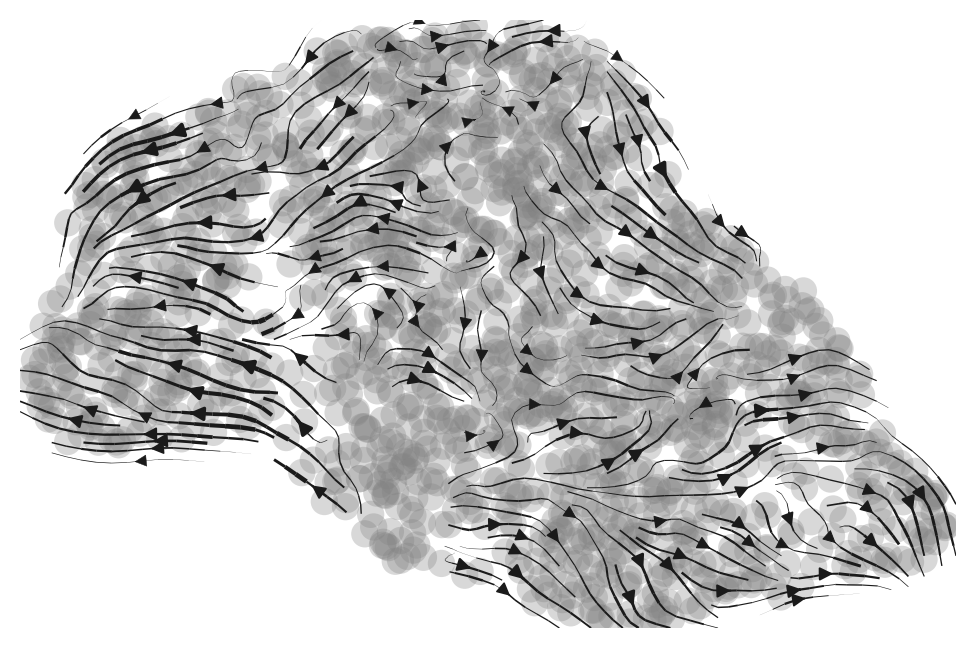

In [19]:

w_ck = vk.copy()
w_ck.transition_matrix = combined_kernel5.transition_matrix
w_ck.transition_matrix = combined_kernel5.transition_matrix
w_ck.plot_projection(basis="umap", key_added='T_fwd_wck5')


saving figure to file ./figures/scvelo_scvelo_20230620_fibro_Dinithi_velo_pk_5to5_newembedding.png


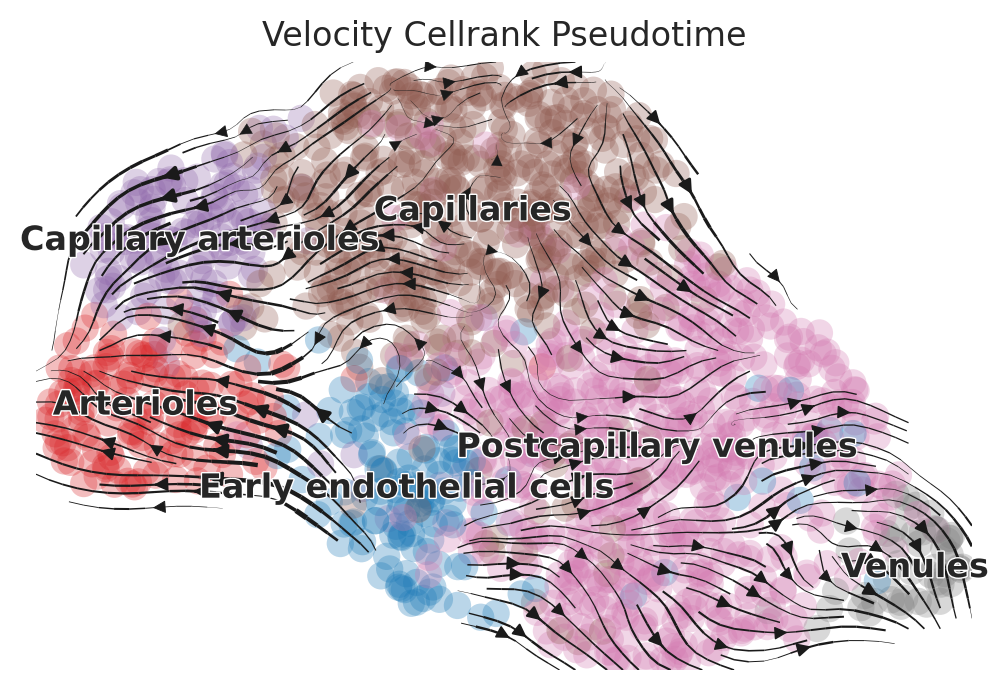

In [53]:
scv.pl.velocity_embedding_stream(adata, color=var_name,basis="umap",vkey="T_fwd_wck5", legend_fontsize=12, title="Velocity Cellrank Pseudotime", smooth=0.8, min_mass=3, save='scvelo_20230620_fibro_Dinithi_velo_pk_5to5_newembedding.png')

# Palantir Velocity Kernel

GPCCA[kernel=(0.5 * VelocityKernel[n=1567] + 0.5 * PseudotimeKernel[n=1567]), initial_states=None, terminal_states=None]
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10, 14, 17, 21, 23, 25]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10, 14, 17]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Calculating minChi criterion in interval `[4, 19]`
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


GPCCA[kernel=(0.5 * VelocityKernel[n=1567] + 0.5 * PseudotimeKernel[n=1567]), initial_states=None, terminal_states=None]

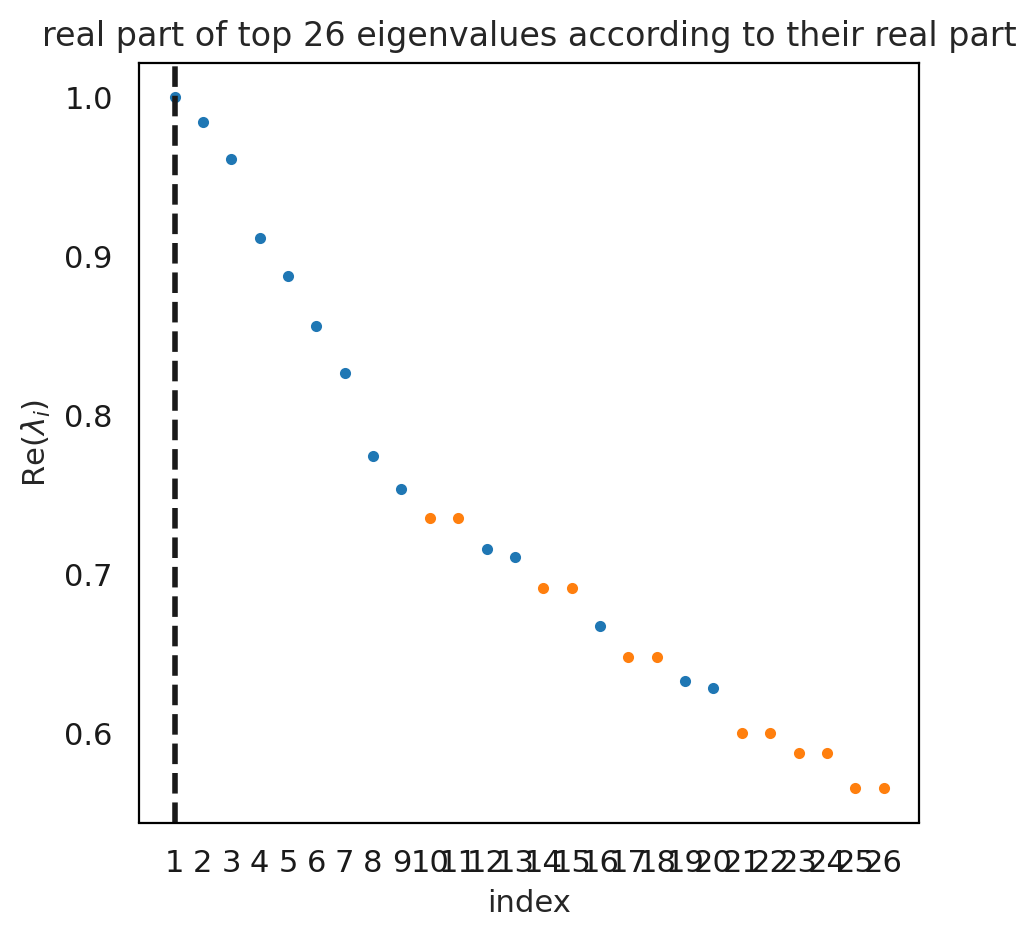

In [20]:
e = cr.estimators.GPCCA(combined_kernel5)
print(e)
e.compute_schur(n_components=25)
e.plot_spectrum(real_only=True)

e.fit(cluster_key=var_name, n_states=[4, 19])


Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


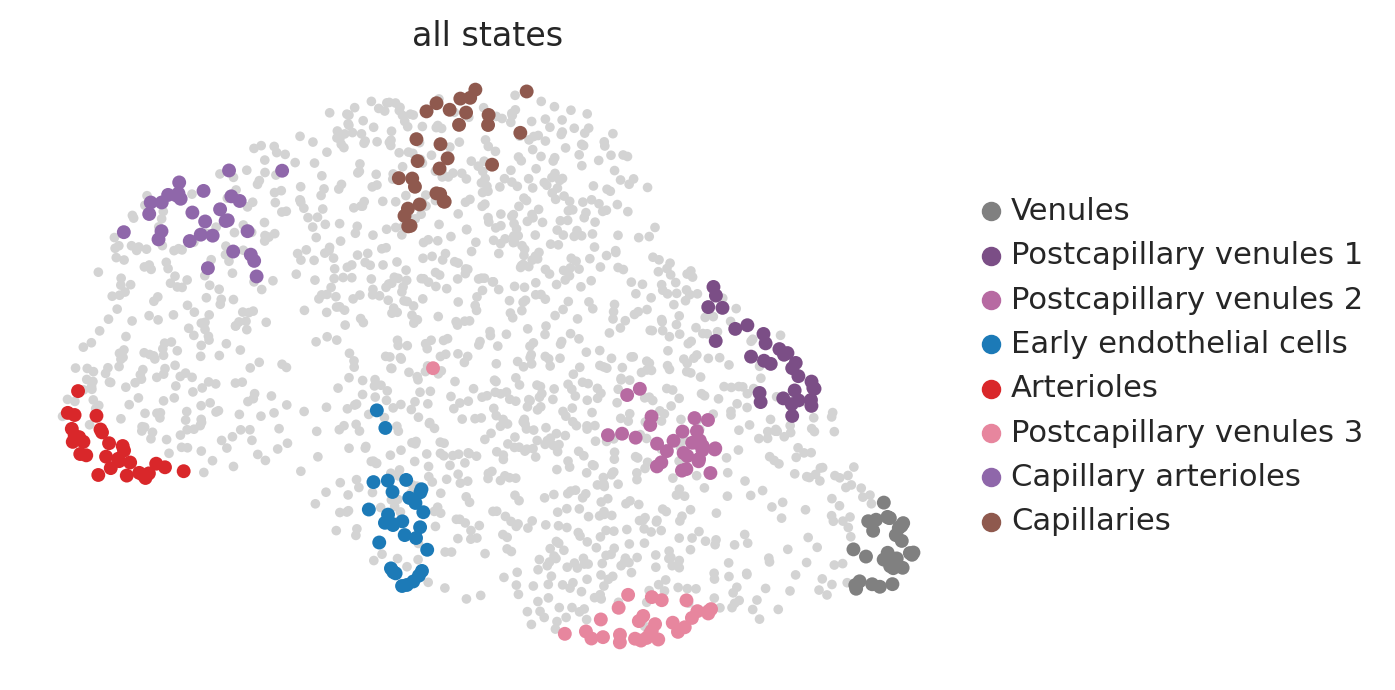

In [21]:
# Here vary a bit to best present data
e.compute_macrostates(n_states=8, cluster_key=var_name)
e.plot_macrostates(which="all", legend_loc="right", s=100)


Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


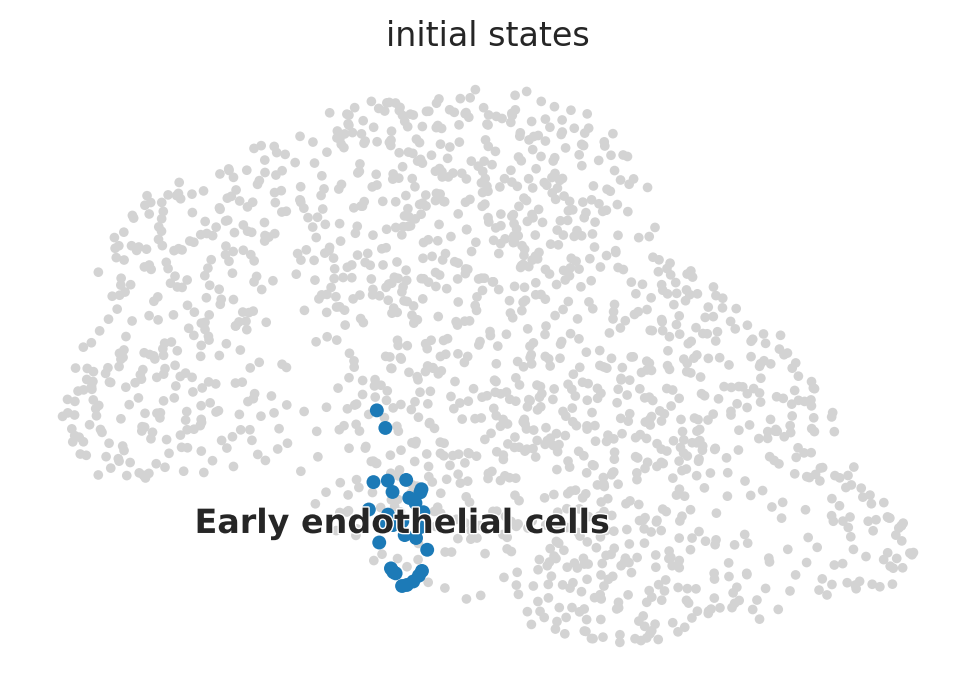

In [22]:
e.set_initial_states(states=["Early endothelial cells"], allow_overlap=True)
e.plot_macrostates(which="initial", s=100)


Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


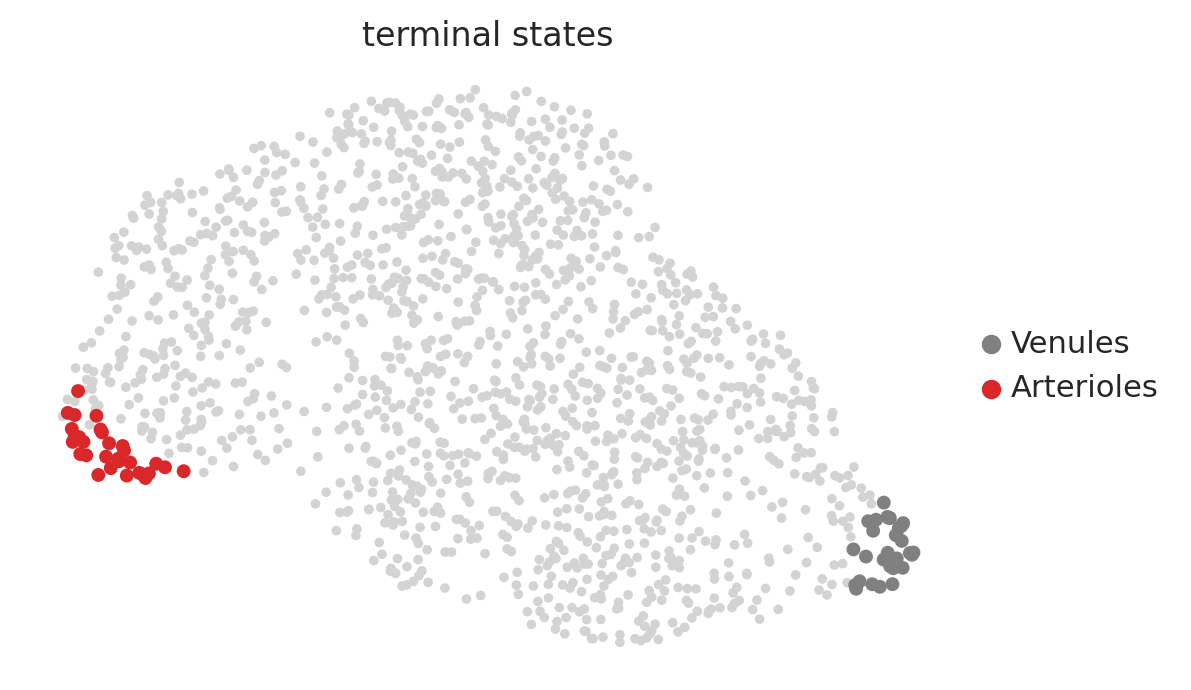

In [23]:
e.set_terminal_states(states=[ 'Venules', 'Arterioles'], allow_overlap=True)
e.plot_macrostates(which="terminal", legend_loc="right", s=100)


In [24]:
e.compute_fate_probabilities()
e.compute_lineage_drivers()


Computing fate probabilities


  0%|          | 0/2 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


Fatal Python error: PyThreadState_Get: no current thread
Python runtime state: initialized

Current thread 0x00007f8a565ca700 (most recent call first):
  File "/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/multiprocessing/connection.py", line 368 in _send
  File "/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/multiprocessing/connection.py", line 411 in _send_bytes
  File "/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/multiprocessing/connection.py", line 206 in send
  File "/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/multiprocessing/managers.py", line 216 in handle_request
  File "/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/threading.py", line 870 in run
  File "/home/jovya

Venules_corr   Venules_pval   Venules_qval  Venules_ci_low  \
MMRN1        0.664059  1.057522e-219  5.906262e-216        0.635435   
CLU          0.632856  2.208135e-191  4.110811e-188        0.602210   
TFPI         0.617621  6.693244e-179  9.345442e-176        0.586024   
ARL4A        0.590279  2.055036e-158  2.295475e-155        0.557042   
VCAN         0.588673  2.788564e-157  2.224876e-154        0.555343   
...               ...            ...            ...             ...   
EFCAB14     -0.528945  6.942486e-120  3.231149e-117       -0.563700   
UNC5B       -0.535176  2.160763e-123  1.097078e-120       -0.569600   
EGFL8       -0.549167  1.398795e-131  8.680302e-129       -0.582837   
PRND        -0.588892  1.956086e-157  1.820790e-154       -0.620322   
IGFBP3      -0.638126  6.792577e-196  1.896827e-192       -0.666582   

         Venules_ci_high  Arterioles_corr  Arterioles_pval  Arterioles_qval  \
MMRN1           0.690860        -0.664058    1.058150e-219    5.909769e-216   
CLU             0.661641        -0.632856    2.212126e-191    4.118241e-188   
TFPI            0.647342        -0.617620    6.702807e-179    9.358794e-176   
ARL4A           0.621628        -0.590278    2.055778e-158    2.296304e-155   
VCAN            0.620116        -0.588673    2.791066e-157    2.226872e-154   
...                  ...              ...              ...              ...   
EFCAB14        -0.492322         0.528946    6.940065e-120    3.230022e-117   
UNC5B          -0.498877         0.535176    2.159306e-123    1.096338e-120   
EGFL8          -0.513616         0.549168    1.397417e-131    8.671751e-129   
PRND           -0.555574         0.588892    1.955591e-157    1.820330e-154   
IGFBP3         -0.607814         0.638127    6.790596e-196    1.896274e-192   

         Arterioles_ci_low  Arterioles_ci_high  
MMRN1            -0.690860           -0.635435  
CLU              -0.661640           -0.602209  
TFPI             -0.647341           -0.586024  
ARL4A            -0.621627           -0.557041  
VCAN             -0.620115           -0.555342  
...                    ...                 ...  
EFCAB14           0.492322            0.563700  
UNC5B             0.498878            0.569600  
EGFL8             0.513616            0.582837  
PRND              0.555574            0.620322  
IGFBP3            0.607814            0.666582  

[5585 rows x 10 columns]

In [28]:
scv.tl.velocity_graph(adata, vkey='VelocityPalantir_matrix')
scv.tl.velocity_pseudotime(adata, vkey='VelocityPalantir_matrix')
scv.tl.latent_time(adata, vkey='VelocityPalantir_matrix', root_key='init_states_fwd_probs', end_key='term_states_fwd_probs')

computing velocities
    finished (0:00:00) --> added 
    'VelocityPalantir_matrix', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/60 cores)


  0%|          | 0/1567 [00:00<?, ?cells/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: [0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:02) --> added 
    'VelocityPalantir_matrix_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using init_states_fwd_probs, term_states_fwd_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


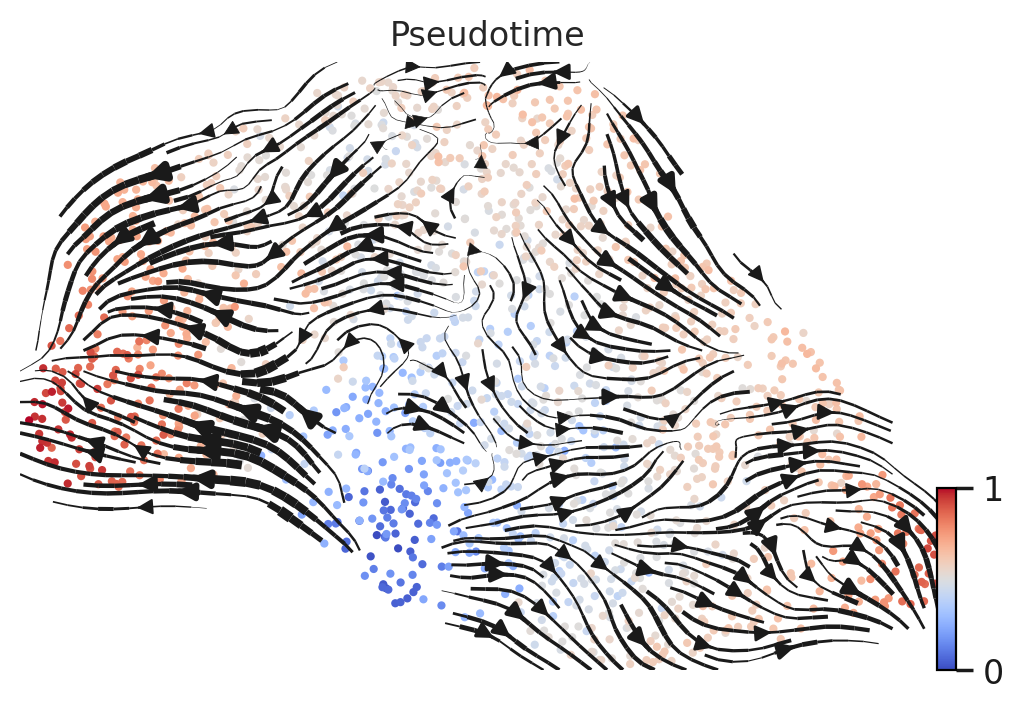

In [29]:
scv.pl.velocity_embedding_stream(adata, color='latent_time',  
                                color_map= 'coolwarm', basis="umap",vkey="T_fwd_wck5", 
                                 legend_fontsize=12, title="Pseudotime", 
                                 smooth=0.8, min_mass=3, arrowsize=1.2, linewidth=2, size=35, alpha=1)

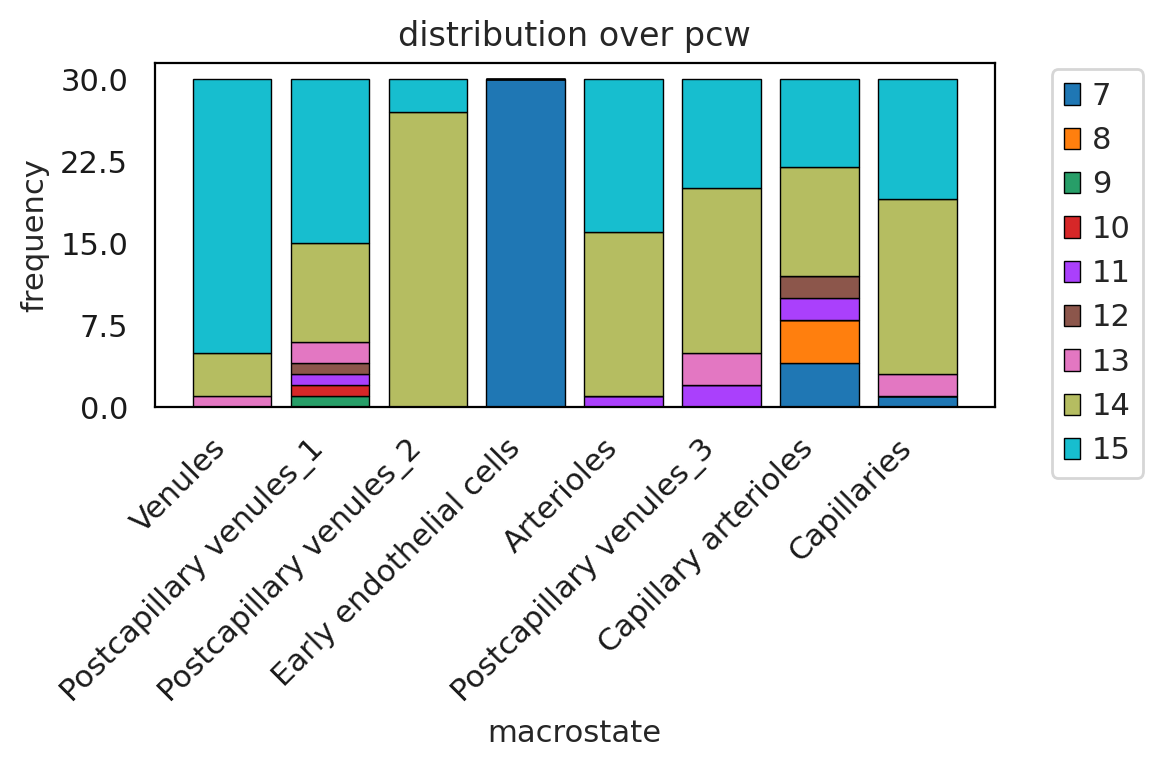

In [25]:
e.plot_macrostate_composition(key="pcw")

running PAGA using priors: ['latent_time']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


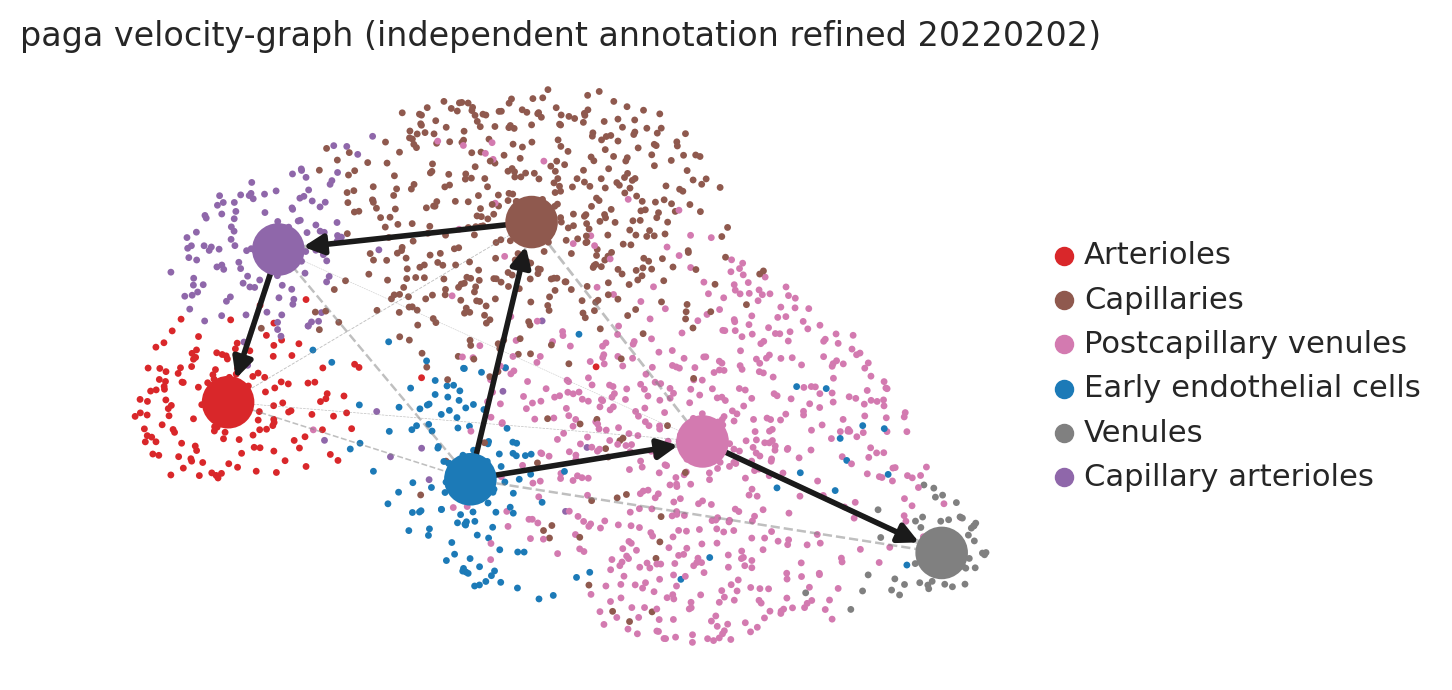

In [30]:
scv.tl.paga(adata, groups=var_name, vkey='velocity', use_time_prior='latent_time')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
scv.pl.paga(adata, basis='umap', title=None, color=var_name, vkey='velocity', node_size_scale=2, node_size_power=0, min_edge_width=2,
            fontsize=0, legend_loc='right', use_raw=False, alpha=1, frameon=False, legend_kwargs=None)


In [92]:
lineagedrivers=e.compute_lineage_drivers()


Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


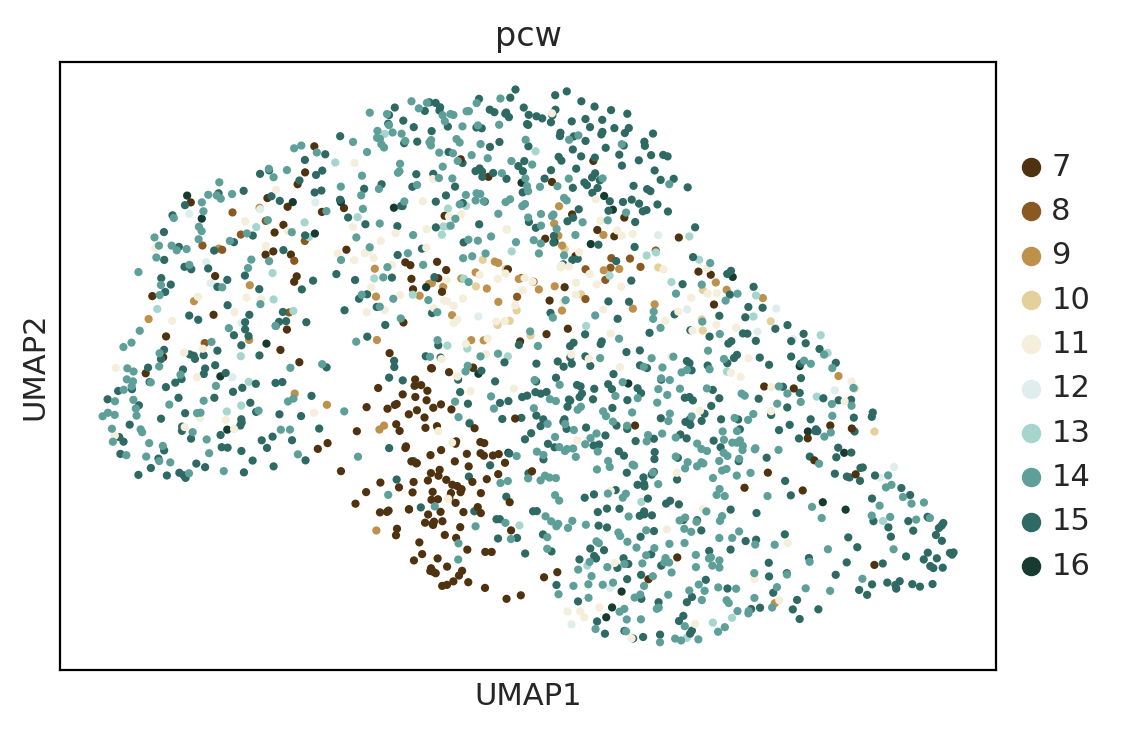

In [31]:
colors_pcw=['#4f3210', '#895921', '#bd904c', '#e3d09b', '#f4eedb', '#dfeeec', '#a5d5cd', '#5ea099', '#2e6963','#163b30']

colors = colors_pcw
adata.uns['pcw'+'_colors'] = colors
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline
sc.pl.umap(adata, color='pcw', alpha=1, size=35)

In [36]:
Arterioles_df = e.compute_lineage_drivers(lineages=["Arterioles"])
Venules_df = e.compute_lineage_drivers(lineages=["Venules"])

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


# Get lineage drivers for each individual population

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


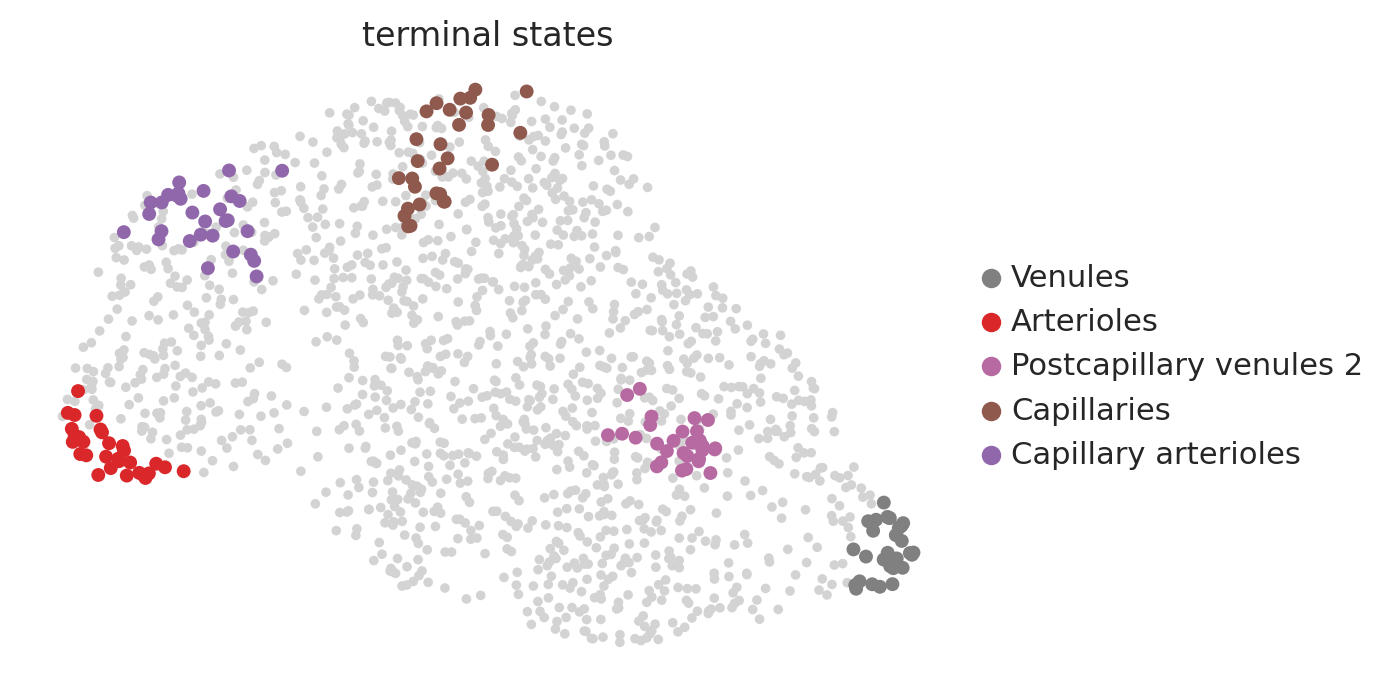

In [33]:
e.set_terminal_states(states=[ 'Venules', 'Arterioles', 'Postcapillary venules_2', "Capillaries", "Capillary arterioles"], allow_overlap=True)
e.plot_macrostates(which="terminal", legend_loc="right", s=100)


In [34]:
e.compute_fate_probabilities()
e.compute_lineage_drivers()


Computing fate probabilities


  0%|          | 0/5 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


Venules_corr   Venules_pval   Venules_qval  Venules_ci_low  \
CLU         0.776216   0.000000e+00   0.000000e+00        0.755746   
VCAN        0.701156  3.645907e-259  1.018120e-255        0.675076   
FBLN2       0.652177  1.895905e-208  3.529544e-205        0.622770   
AKR1C1      0.644913  7.336532e-202  1.024363e-198        0.615036   
SULF1       0.594838  1.134560e-161  1.267303e-158        0.561870   
...              ...            ...            ...             ...   
CAV1       -0.407290   1.518707e-65   2.292427e-63       -0.447778   
COL4A1     -0.421480   1.080958e-70   1.829439e-68       -0.461370   
CLIC1      -0.432823   5.238699e-75   9.143167e-73       -0.472221   
ESAM       -0.468131   1.168192e-89   2.836674e-87       -0.505922   
A2M        -0.542495  1.276166e-127  6.479444e-125       -0.576527   

        Venules_ci_high  Arterioles_corr  Arterioles_pval  Arterioles_qval  \
CLU            0.795171        -0.295443     2.111778e-33     8.424486e-32   
VCAN           0.725486        -0.276320     3.276493e-29     1.070129e-27   
FBLN2          0.679743        -0.236415     1.574595e-21     3.448672e-20   
AKR1C1         0.672942        -0.169828     1.185522e-11     1.356791e-10   
SULF1          0.625921        -0.138039     3.925425e-08     3.172720e-07   
...                 ...              ...              ...              ...   
CAV1          -0.365135         0.129872     2.400978e-07     1.778443e-06   
COL4A1        -0.379889         0.231848     9.745595e-21     2.023388e-19   
CLIC1         -0.391699         0.161522     1.161850e-10     1.215156e-09   
ESAM          -0.428546         0.286798     1.826450e-31     6.456154e-30   
A2M           -0.506585         0.316415     2.116336e-38     9.849780e-37   

        Arterioles_ci_low  Arterioles_ci_high  ...  Capillaries_corr  \
CLU             -0.339989           -0.249576  ...         -0.187812   
VCAN            -0.321441           -0.229947  ...         -0.203784   
FBLN2           -0.282626           -0.189110  ...         -0.264297   
AKR1C1          -0.217518           -0.121329  ...         -0.126940   
SULF1           -0.186285           -0.089129  ...         -0.148524   
...                   ...                 ...  ...               ...   
CAV1             0.080873            0.178245  ...          0.162375   
COL4A1           0.184446            0.278173  ...          0.208930   
CLIC1            0.112906            0.209367  ...          0.164856   
ESAM             0.240697            0.331608  ...          0.077383   
A2M              0.271144            0.360289  ...          0.156788   

        Capillaries_pval  Capillaries_qval  Capillaries_ci_low  \
CLU         5.617817e-14      5.409570e-12           -0.235144   
VCAN        2.994601e-16      4.778528e-14           -0.250772   
FBLN2       9.500086e-27      5.569750e-24           -0.309762   
AKR1C1      4.478709e-07      1.232196e-05           -0.175357   
SULF1       3.268744e-09      1.496388e-07           -0.196597   
...                  ...               ...                 ...   
CAV1        9.242145e-11      5.610585e-09            0.113770   
COL4A1      5.025121e-17      9.677690e-15            0.161077   
CLIC1       4.714290e-11      3.061547e-09            0.116286   
ESAM        2.166176e-03      1.682627e-02            0.027971   
A2M         4.049255e-10      2.239117e-08            0.108108   

        Capillaries_ci_high  Capillary arterioles_corr  \
CLU               -0.139591                  -0.149595   
VCAN              -0.155837                  -0.170245   
FBLN2             -0.217626                  -0.253262   
AKR1C1            -0.077911                  -0.101341   
SULF1             -0.099738                  -0.126519   
...                     ...                        ...   
CAV1               0.210204                   0.023974   
COL4A1             0.255802                   0.199936   
CLIC1              0.212640                   0.13

In [35]:
Capillaries_df = e.compute_lineage_drivers(lineages=["Capillaries"])
Postcapillaryvenules_2_df = e.compute_lineage_drivers(lineages=["Postcapillary venules_2"])
Capillaryarterioles_df = e.compute_lineage_drivers(lineages=["Capillary arterioles"])


Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
